<a href="https://colab.research.google.com/github/AmirRezaBehzad/IRD-Based-Medical-Image-Steganography/blob/main/IRDBasedSteganography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Step 0: Importing Libraries and Modules

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.metrics import structural_similarity as ssim
import pandas as pd
from dataclasses import dataclass
from typing import Tuple, Dict

# Step 1: MRI Image Loading and Global Intensity Analysis


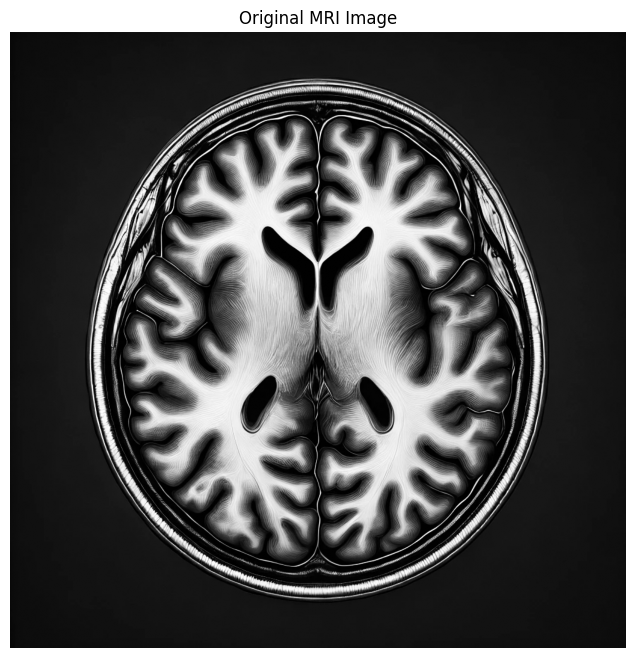

Image Loaded Successfully!
 → Dimensions: Height = 1024 px, Width = 1024 px

Minimum Intensity Value in the Entire Image: 0
 → First occurrence found at (row=77, col=471)
 (Note: This is the first occurrence scanned; there may be others)

Maximum Intensity Value in the Entire Image: 255
 → First occurrence found at (row=97, col=421)
 (Note: This is the first occurrence scanned; there may be others)

Mean Intensity of Entire Image: 64.32
Standard Deviation of Intensities (Full Image): 76.09



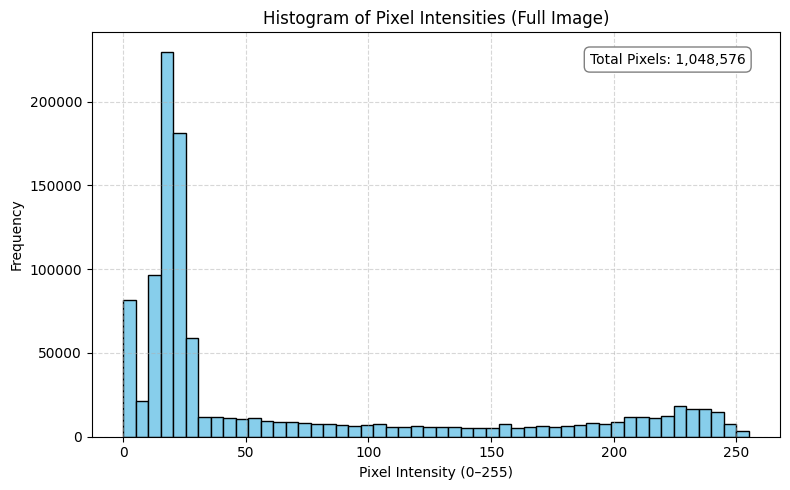

In [3]:
# Load the MRI image
image_path = "/content/drive/MyDrive/Brain MRI Images/Brain_Image_3.webp"
original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale

# Check if the image is loaded
if original_img is None:
    print("Error: Image not found. Please check the file path!")
else:
    # Display the image
    plt.figure(figsize=(8, 8))
    plt.imshow(original_img, cmap='gray')
    plt.title("Original MRI Image")
    plt.axis('off')
    plt.show()

    # Get image dimensions
    height, width = original_img.shape
    # print(f"✅ Image Loaded Successfully! Dimensions: {height}x{width}")
    print(f"Image Loaded Successfully!")
    print(f" → Dimensions: Height = {height} px, Width = {width} px")

    # Min/Max intensity and positions
    min_intensity = np.min(original_img)
    max_intensity = np.max(original_img)
    min_position = np.unravel_index(np.argmin(original_img), original_img.shape)
    max_position = np.unravel_index(np.argmax(original_img), original_img.shape)

    print(f"\nMinimum Intensity Value in the Entire Image: {min_intensity}")
    print(f" → First occurrence found at (row={min_position[0]}, col={min_position[1]})")
    print(f" (Note: This is the first occurrence scanned; there may be others)\n")

    print(f"Maximum Intensity Value in the Entire Image: {max_intensity}")
    print(f" → First occurrence found at (row={max_position[0]}, col={max_position[1]})")
    print(f" (Note: This is the first occurrence scanned; there may be others)\n")

    # Mean and Standard Deviation
    mean_intensity = np.mean(original_img)
    std_intensity = np.std(original_img)
    print(f"Mean Intensity of Entire Image: {mean_intensity:.2f}")
    print(f"Standard Deviation of Intensities (Full Image): {std_intensity:.2f}\n")

    # Histogram
    plt.figure(figsize=(8, 5))
    plt.hist(original_img.ravel(), bins=50, color='skyblue', edgecolor='black')

    total_pixels = original_img.size
    plt.title("Histogram of Pixel Intensities (Full Image)")
    plt.xlabel("Pixel Intensity (0–255)")
    plt.ylabel("Frequency")

    # Add total pixel count as a text box in the plot
    plt.text(0.95, 0.95, f"Total Pixels: {total_pixels:,}",
            verticalalignment='top',
            horizontalalignment='right',
            transform=plt.gca().transAxes,
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.4'))

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


# Step 2: Intensity-Based Image Segmentation and Histogram Visualization

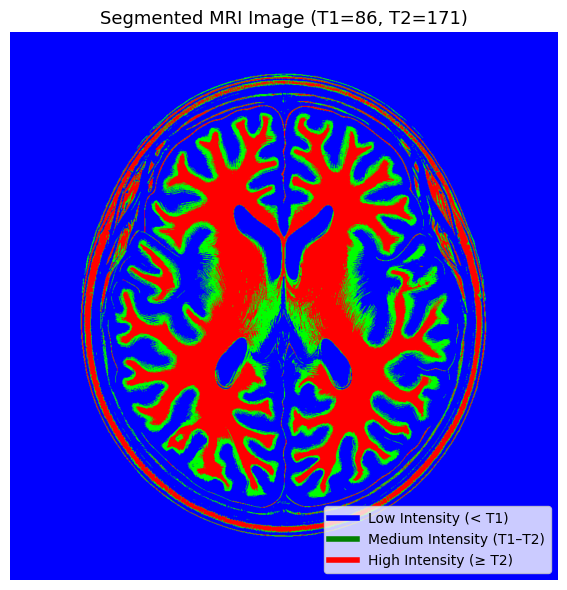


Segmentation Summary:
 - Threshold 1 (T1): 86
 - Threshold 2 (T2): 171

🟦 Low-Intensity Region (< 86): 775,278 pixels (73.94%)
🟩 Medium-Intensity Region (86 ≤ pixel < 171): 102,048 pixels (9.73%)
🟥 High-Intensity Region (≥ 171): 171,250 pixels (16.33%)



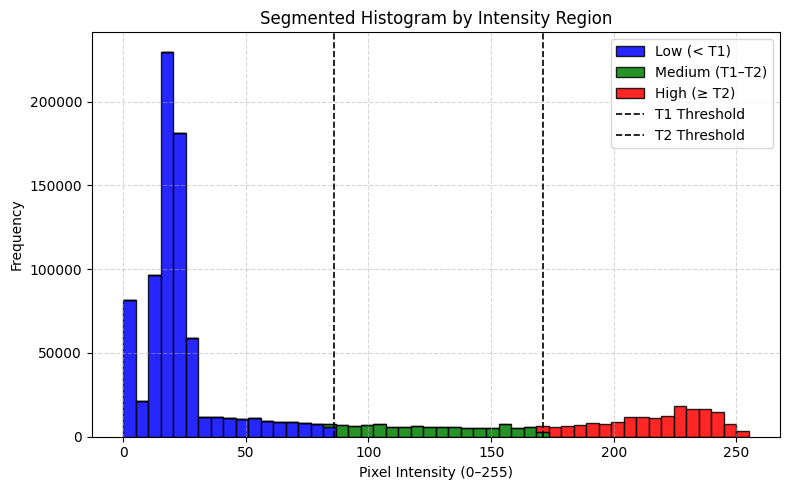

In [4]:
# Thresholds for segmentation (can be tuned or made adaptive)
t1 = 86   # Threshold separating Low and Medium intensities
t2 = 171  # Threshold separating Medium and High intensities

# Segment the image into 3 intensity-based regions
def segment_image(image, t1, t2):
    low_intensity = (image < t1)
    medium_intensity = (image >= t1) & (image < t2)
    high_intensity = (image >= t2)
    return low_intensity, medium_intensity, high_intensity

# Apply segmentation
low_region, medium_region, high_region = segment_image(original_img, t1, t2)

# Create a color-coded RGB visualization
segmented_img = np.zeros((*original_img.shape, 3), dtype=np.uint8)
segmented_img[low_region] = [0, 0, 255]      # Blue for Low
segmented_img[medium_region] = [0, 255, 0]   # Green for Medium
segmented_img[high_region] = [255, 0, 0]     # Red for High

# Display segmented image with legend
plt.figure(figsize=(6, 6))
plt.imshow(segmented_img)
plt.title(f"Segmented MRI Image (T1={t1}, T2={t2})", fontsize=13)
plt.axis('off')

legend_patches = [
    plt.Line2D([0], [0], color='blue', lw=4, label='Low Intensity (< T1)'),
    plt.Line2D([0], [0], color='green', lw=4, label='Medium Intensity (T1–T2)'),
    plt.Line2D([0], [0], color='red', lw=4, label='High Intensity (≥ T2)'),
]
plt.legend(handles=legend_patches, loc='lower right', frameon=True, fontsize=10)
plt.tight_layout()
plt.show()

# === Report Pixel Distribution in Each Region ===
total_pixels = original_img.size
low_count = np.sum(low_region)
med_count = np.sum(medium_region)
high_count = np.sum(high_region)

low_pct = low_count / total_pixels * 100
med_pct = med_count / total_pixels * 100
high_pct = high_count / total_pixels * 100

print("\nSegmentation Summary:")
print(f" - Threshold 1 (T1): {t1}")
print(f" - Threshold 2 (T2): {t2}\n")

print(f"🟦 Low-Intensity Region (< {t1}): {low_count:,} pixels ({low_pct:.2f}%)")
print(f"🟩 Medium-Intensity Region ({t1} ≤ pixel < {t2}): {med_count:,} pixels ({med_pct:.2f}%)")
print(f"🟥 High-Intensity Region (≥ {t2}): {high_count:,} pixels ({high_pct:.2f}%)\n")

# === Optional: Segmentation-Aware Histogram ===
low_values = original_img[original_img < t1]
med_values = original_img[(original_img >= t1) & (original_img < t2)]
high_values = original_img[original_img >= t2]

plt.figure(figsize=(8, 5))
plt.hist([low_values.ravel(), med_values.ravel(), high_values.ravel()],
         bins=50,
         stacked=True,
         color=['blue', 'green', 'red'],
         label=['Low (< T1)', 'Medium (T1–T2)', 'High (≥ T2)'],
         edgecolor='black',
         alpha=0.85)

# Mark thresholds visually
plt.axvline(x=t1, color='black', linestyle='--', linewidth=1.2, label='T1 Threshold')
plt.axvline(x=t2, color='black', linestyle='--', linewidth=1.2, label='T2 Threshold')

plt.title("Segmented Histogram by Intensity Region")
plt.xlabel("Pixel Intensity (0–255)")
plt.ylabel("Frequency")
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Step 3: Embedding Text in Image Pixels


========== Embedding Process ==========
Message to embed: "Patient ID: 0423
Name: John Doe
Age: 54
Diagnosis: Early-stage glioma detected in left temporal lobe.
Prescribed Treatment: Begin radiotherapy within two weeks.
Follow-up: Schedule MRI scan in 3 months for progression analysis.
Note: Imaging data must remain confidential under HIPAA compliance."
Message length: 295 characters
Image dimensions: 1024 x 1024 (1048576 pixels)
Starting the embedding process...

Pixel           Original   Updated    Region  Bit
-------------------------------------------------
(0,0)                  9         9       Low    0
(0,1)                  9        12       Low    1
(0,2)                  9         9       Low    0
(0,3)                  9        12       Low    1
(0,4)                 11        11       Low    0
(0,5)                 11        11       Low    0
(0,6)                 11        11       Low    0
(0,7)                 11        11       Low    0
(0,8)                 15      

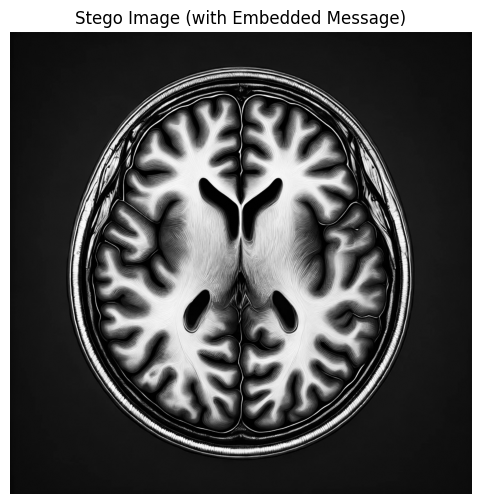

In [5]:
# Thresholds from the article
t1, t2 = 86, 171

def embed_ird(image: np.ndarray, message: str, verbose=False) -> np.ndarray:
    DELIM = '1111111111111110'
    bin_msg = ''.join(f"{ord(c):08b}" for c in message) + DELIM
    nbits = len(bin_msg)
    if nbits > image.size:
        raise ValueError(f"Message needs {nbits} bits but image only has {image.size} pixels.")

    stego = image.copy().astype(int)
    idx = 0

    if verbose:
        print(f"{'Pixel':<14}{'Original':>10}{'Updated':>10}{'Region':>10}{'Bit':>5}")
        print("-" * 49)

    for i in range(stego.shape[0]):
        for j in range(stego.shape[1]):
            if idx >= nbits:
                break

            g = stego[i, j]
            bit = int(bin_msg[idx])

            if g < t1:
                region = 'Low'
                hold = g & 0b111
                if bit == 0:
                    if hold >= 4:
                        if hold == 4:
                            new = (g - 4) + 3
                        elif hold == 5:
                            new = (g - 4) + 2
                        elif hold == 6:
                            new = (g - 4) + 1
                        elif hold == 7:
                            new = (g - 4)
                    else:
                        new = g
                else:
                    new = (g | 0b111) - 3 if hold <= 3 else g

            elif g < t2:
                region = 'Medium'
                hold = g & 0b11
                if bit == 0:
                    if hold >= 2:
                        if hold == 2:
                            new = (g - 2) + 1
                        elif hold == 3:
                            new = (g - 2)
                    else:
                        new = g
                else:
                    new = (g | 0b11) - 1 if hold <= 1 else g

            else:
                region = 'High'
                new = (g & 0b11111110) | bit

            if verbose:
                print(f"({i},{j})".ljust(14) + f"{g:10d}{new:10d}{region:>10}{bit:5d}")

            stego[i, j] = np.clip(new, 0, 255)
            idx += 1

        if idx >= nbits:
            break

    if idx < nbits:
        print(f"⚠️ Only embedded {idx}/{nbits} bits!")

    return stego.astype(np.uint8)

def extract_ird(stego: np.ndarray, verbose=False) -> str:
    bits = []
    for i in range(stego.shape[0]):
        for j in range(stego.shape[1]):
            g = int(stego[i, j])
            if g < t1:
                b = (g >> 2) & 1
            elif g < t2:
                b = (g >> 1) & 1
            else:
                b = g & 1
            bits.append(str(b))
            if verbose and len(bits) < 64:
                print(f"Pixel[{i},{j}] = {g:3d} => bit = {b}")

    bitstr = ''.join(bits)
    parts = bitstr.split('1111111111111110', 1)
    data = parts[0]
    chars = [chr(int(data[k:k+8], 2)) for k in range(0, len(data), 8)]
    return ''.join(chars)

# ---------------- MAIN PROGRAM STARTS HERE ---------------- #

# Example: load a dummy image
# original_img = np.random.randint(0, 256, size=(512, 512), dtype=np.uint8)

# Message to embed
message = (
    "Patient ID: 0423\n"
    "Name: John Doe\n"
    "Age: 54\n"
    "Diagnosis: Early-stage glioma detected in left temporal lobe.\n"
    "Prescribed Treatment: Begin radiotherapy within two weeks.\n"
    "Follow-up: Schedule MRI scan in 3 months for progression analysis.\n"
    "Note: Imaging data must remain confidential under HIPAA compliance."
)

# Show clean embedding info
print("\n========== Embedding Process ==========")
print(f"Message to embed: \"{message}\"")
print(f"Message length: {len(message)} characters")
print(f"Image dimensions: {original_img.shape[0]} x {original_img.shape[1]} ({original_img.size} pixels)")
print("Starting the embedding process...\n")

# Embed the message
stego_img = embed_ird(original_img, message, verbose=True)

print("\n✅ Embedding completed successfully!\n")

# Display only the Stego Image
plt.figure(figsize=(6, 6))
plt.title("Stego Image (with Embedded Message)")
plt.imshow(stego_img, cmap='gray')
plt.axis('off')
plt.show()

# Extraction will be handled separately if needed
# extracted_message = extract_ird(stego_img, verbose=True)
# print("\nExtracted Message:", extracted_message)


# Step 4: Quality Metrics – MSE, PSNR, SSIM


Image Quality Metrics:
 Mean Squared Error (MSE): 0.0071
 Peak Signal-to-Noise Ratio (PSNR): 69.60 dB
 Structural Similarity Index (SSIM): 1.0000



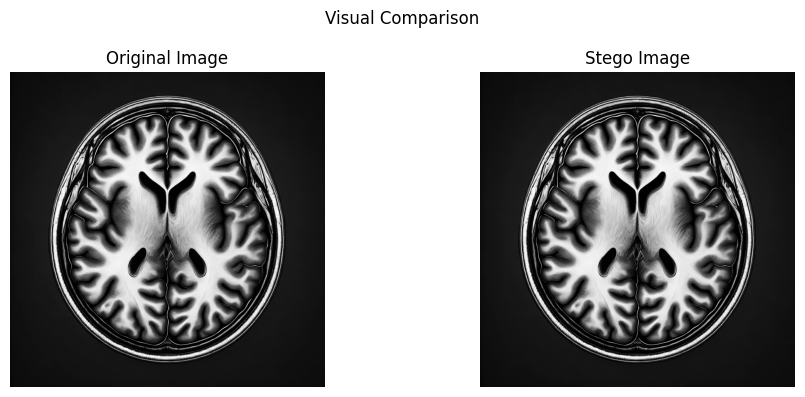

In [6]:
def compute_metrics(original, stego):
    """
    Computes and optionally prints MSE, PSNR, and SSIM between two grayscale images.

    Parameters:
        original (np.ndarray): Original grayscale image.
        stego (np.ndarray): Stego (modified) grayscale image.

    Returns:
        tuple: (mse, psnr, ssim_index)
    """
    # Validation
    if original.shape != stego.shape:
        raise ValueError("❌ Error: Input images must have the same dimensions.")

    # Compute MSE
    mse = np.mean((original - stego) ** 2)

    # Compute PSNR
    if mse == 0:
        psnr = float('inf')
    else:
        psnr = 10 * np.log10((255 ** 2) / mse)

    # Compute SSIM (set data_range explicitly)
    ssim_index = ssim(original, stego, data_range=255)


    print("\nImage Quality Metrics:")
    print(f" Mean Squared Error (MSE): {mse:.4f}")
    print(f" Peak Signal-to-Noise Ratio (PSNR): {psnr:.2f} dB")
    print(f" Structural Similarity Index (SSIM): {ssim_index:.4f}\n")

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(stego, cmap='gray')
    plt.title("Stego Image")
    plt.axis('off')

    plt.suptitle("Visual Comparison")
    plt.tight_layout()
    plt.show()

    return mse, psnr, ssim_index


mse_val, psnr_val, ssim_val = compute_metrics(original_img, stego_img)


# Step 5: Extracting the Hidden Message

In [7]:
def extract_ird(stego: np.ndarray, verbose=False) -> str:
    bits = []

    if verbose:
        print("\n========== Extraction Process ==========")
        print(f"{'Pixel':<14}{'Intensity':>12}{'Region':>12}{'Extracted Bit':>18}")
        print("-" * 60)

    for i in range(stego.shape[0]):
        for j in range(stego.shape[1]):
            g = int(stego[i, j])
            if g < t1:
                region = 'Low'
                b = (g >> 2) & 1
            elif g < t2:
                region = 'Medium'
                b = (g >> 1) & 1
            else:
                region = 'High'
                b = g & 1
            bits.append(str(b))
            if verbose and len(bits) < 64:  # Only show first 64 bits
                print(f"({i},{j})".ljust(14) + f"{g:12d}{region:>12}{b:18d}")

    bitstr = ''.join(bits)
    parts = bitstr.split('1111111111111110', 1)
    data = parts[0]
    chars = [chr(int(data[k:k+8], 2)) for k in range(0, len(data), 8)]

    if verbose:
        print("\n✅ Extraction completed successfully.\n")

    return ''.join(chars)

extracted_message = extract_ird(stego_img, verbose=True)
print("\nExtracted Message:", extracted_message)


========== Extraction Process ==========
Pixel            Intensity      Region     Extracted Bit
------------------------------------------------------------
(0,0)                    9         Low                 0
(0,1)                   12         Low                 1
(0,2)                    9         Low                 0
(0,3)                   12         Low                 1
(0,4)                   11         Low                 0
(0,5)                   11         Low                 0
(0,6)                   11         Low                 0
(0,7)                   11         Low                 0
(0,8)                   11         Low                 0
(0,9)                   15         Low                 1
(0,10)                  15         Low                 1
(0,11)                  11         Low                 0
(0,12)                  11         Low                 0
(0,13)                  11         Low                 0
(0,14)                  11         Low    

# Step 6: Evaluation and Visualization of Stego Results

 Processing: First Brain MRI Image
Message to embed: "Patient ID: 0423
Name: John Doe
Age: 54
Diagnosis: Early-stage glioma detected in left temporal lobe.
Prescribed Treatment: Begin radiotherapy within two weeks.
Follow-up: Schedule MRI scan in 3 months for progression analysis.
Note: Imaging data must remain confidential under HIPAA compliance."
Image size: 1285 x 1200 (1542000 pixels)
Starting the embedding process...

✅ Embedding completed successfully!



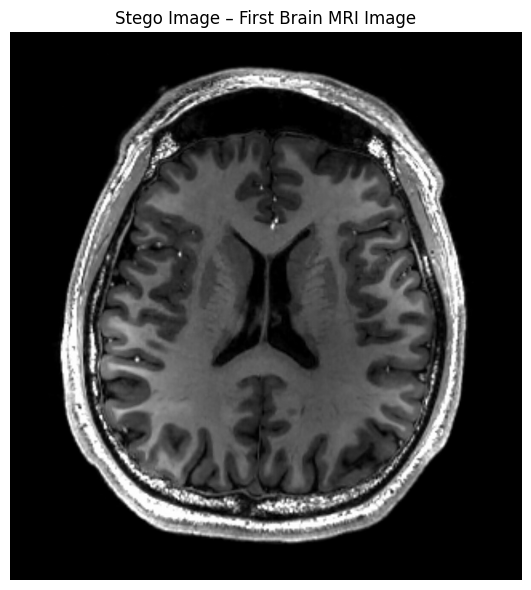

 Processing: Second Brain MRI Image
Message to embed: "Patient ID: 0423
Name: John Doe
Age: 54
Diagnosis: Early-stage glioma detected in left temporal lobe.
Prescribed Treatment: Begin radiotherapy within two weeks.
Follow-up: Schedule MRI scan in 3 months for progression analysis.
Note: Imaging data must remain confidential under HIPAA compliance."
Image size: 340 x 535 (181900 pixels)
Starting the embedding process...

✅ Embedding completed successfully!



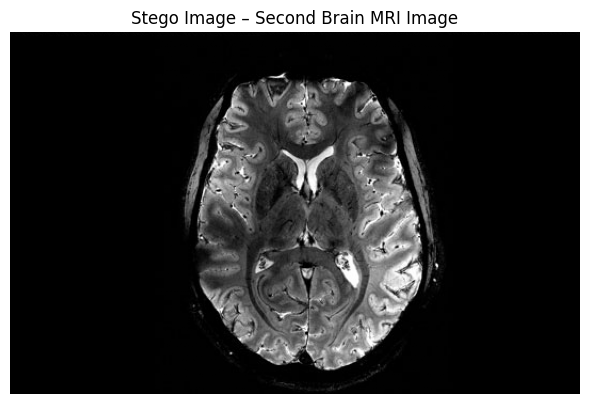

 Processing: Third Brain MRI Image
Message to embed: "Patient ID: 0423
Name: John Doe
Age: 54
Diagnosis: Early-stage glioma detected in left temporal lobe.
Prescribed Treatment: Begin radiotherapy within two weeks.
Follow-up: Schedule MRI scan in 3 months for progression analysis.
Note: Imaging data must remain confidential under HIPAA compliance."
Image size: 442 x 442 (195364 pixels)
Starting the embedding process...

✅ Embedding completed successfully!



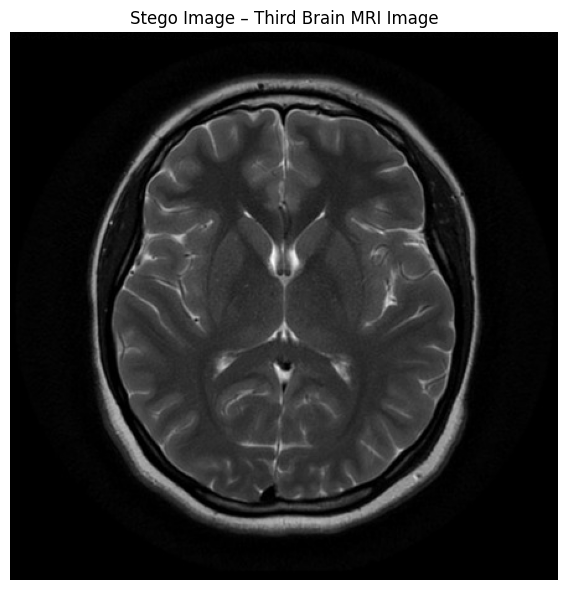


========== Final Comparison Table ==========
                    Image Message Match  Accuracy (%)     MSE  PSNR (dB)  SSIM
0   First Brain MRI Image           Yes         100.0  0.0114      67.56   1.0
1  Second Brain MRI Image           Yes         100.0  0.0881      58.68   1.0
2   Third Brain MRI Image           Yes         100.0  0.0899      58.59   1.0


In [8]:
# === Define test image paths ===
test_images = [
    "/content/drive/MyDrive/Brain MRI Images/Brain_Image_1.jpg",
    "/content/drive/MyDrive/Brain MRI Images/Brain_Image_2.jpg",
    "/content/drive/MyDrive/Brain MRI Images/Brain_Image_4.jpeg",
]

# === Friendly labels for reporting ===
image_labels = [
    "First Brain MRI Image",
    "Second Brain MRI Image",
    "Third Brain MRI Image"
]

# === Define the secret message to embed ===
secret_message = (
    "Patient ID: 0423\n"
    "Name: John Doe\n"
    "Age: 54\n"
    "Diagnosis: Early-stage glioma detected in left temporal lobe.\n"
    "Prescribed Treatment: Begin radiotherapy within two weeks.\n"
    "Follow-up: Schedule MRI scan in 3 months for progression analysis.\n"
    "Note: Imaging data must remain confidential under HIPAA compliance."
)

# === Result table list ===
results_table = []

def text_to_binary(text):
    return ''.join(f"{ord(c):08b}" for c in text)

def compute_metrics(original, stego):
    mse = ((original - stego) ** 2).mean()
    psnr = 10 * np.log10(255**2 / mse) if mse != 0 else float('inf')
    ssim = compute_ssim(original, stego)
    return mse, psnr, ssim

def compute_ssim(img1, img2):
    """ Simple SSIM approximation for grayscale images """
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2
    mu1 = img1.mean()
    mu2 = img2.mean()
    sigma1 = img1.std()
    sigma2 = img2.std()
    covariance = np.mean((img1 - mu1) * (img2 - mu2))
    ssim = ((2 * mu1 * mu2 + C1) * (2 * covariance + C2)) / ((mu1**2 + mu2**2 + C1) * (sigma1**2 + sigma2**2 + C2))
    return ssim

def visualize_and_evaluate_embedding(images, labels, message, save_figures=False):
    """
    Embeds a secret message into a list of grayscale images using the IRD method,
    displays the Stego Image, and computes quality metrics.

    Parameters:
        images (list): Paths to input MRI images.
        labels (list): Human-readable names for each image.
        message (str): Secret message to embed into the image.
        save_figures (bool): Whether to save the output figures to disk.
    """
    for path, label in zip(images, labels):
        print("=" * 60)
        print(f" Processing: {label}")
        print("=" * 60)

        # Load image
        original_img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if original_img is None:
            print(f"[ERROR] Failed to load image: {path}")
            continue

        # Show initial info
        print(f"Message to embed: \"{message}\"")
        print(f"Image size: {original_img.shape[0]} x {original_img.shape[1]} ({original_img.size} pixels)")
        print("Starting the embedding process...\n")

        # Embed message
        stego_img = embed_ird(original_img, message, verbose=False)

        print("✅ Embedding completed successfully!\n")

        # Extract message
        extracted_msg = extract_ird(stego_img, verbose=False)

        # Compute bitwise accuracy
        original_bin = text_to_binary(message)
        extracted_bin = text_to_binary(extracted_msg)
        correct_bits = sum(a == b for a, b in zip(original_bin, extracted_bin))
        accuracy = round((correct_bits / len(original_bin)) * 100, 2)
        message_match = "Yes" if message == extracted_msg else "No"

        # Compute image quality metrics
        mse, psnr, ssim = compute_metrics(original_img, stego_img)

        # Append results to table
        results_table.append({
            "Image": label,
            "Message Match": message_match,
            "Accuracy (%)": accuracy,
            "MSE": round(mse, 4),
            "PSNR (dB)": round(psnr, 2),
            "SSIM": round(ssim, 4)
        })

        # Plot ONLY the Stego Image (no side-by-side here)
        plt.figure(figsize=(6, 6))
        plt.title(f"Stego Image – {label}")
        plt.imshow(stego_img, cmap='gray')
        plt.axis('off')
        plt.tight_layout()
        if save_figures:
            filename = f"stego_image_{label.replace(' ', '_').lower()}.png"
            plt.savefig(filename)
            print(f"[Saved] {filename}")
        plt.show()

# === Run visualization and evaluation ===
visualize_and_evaluate_embedding(test_images, image_labels, secret_message, save_figures=False)

# === Display summary table ===
df_results = pd.DataFrame(results_table)
print("\n========== Final Comparison Table ==========")
print(df_results)


# Step 7: Message Recovery Under Noisy Conditions

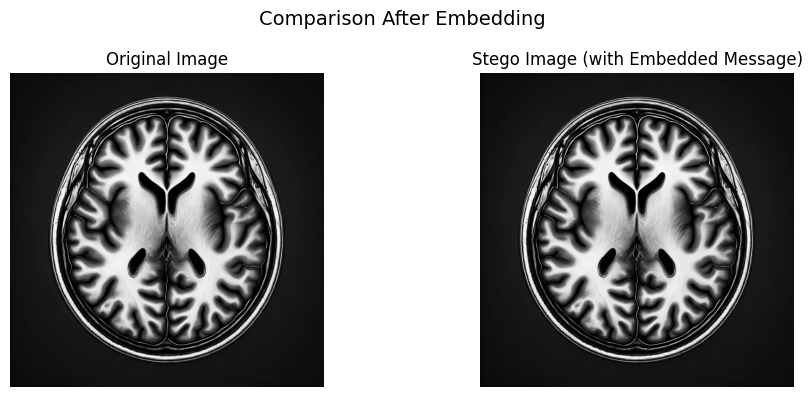


 Evaluating Extraction Robustness Under Gaussian Noise

🔹 Noise Level σ = 0.5


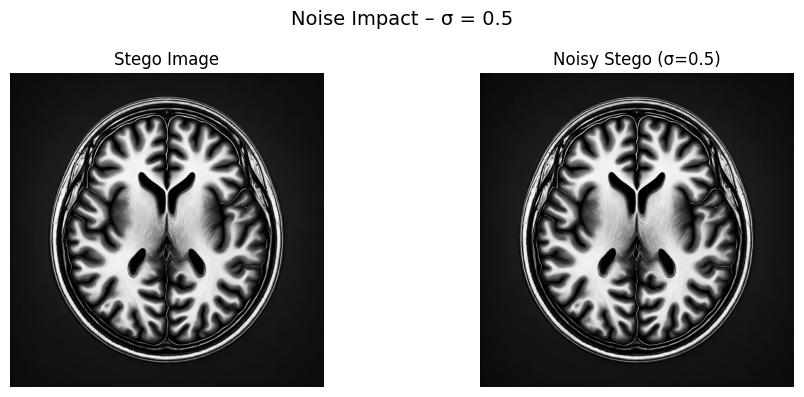

   Bitwise Accuracy: 81.36%
   Full Message Match: ❌
   Extracted Message: "a°	AÚ< : 042
JaM/: L@n @| !dE* µt
d qFéc)s@eblx|age ddiom@ dd%btMd!in0D%&4 T`gporA` A#`.
Pp@bc*@-   æE` m#|^ÇBe`* " iothepapi¸phVhhn!tw« pc3Â `@l#&(0¡H¡@ed@EPH B!` `n "od`` fr r-'rexã(iF !nALå$s6Õhpe" Imaghng"di` iust rae in æ´¼@$æ@led`2 @IP   cï-plkanceCN)©ò/W              D       ô @  þ"


🔹 Noise Level σ = 1


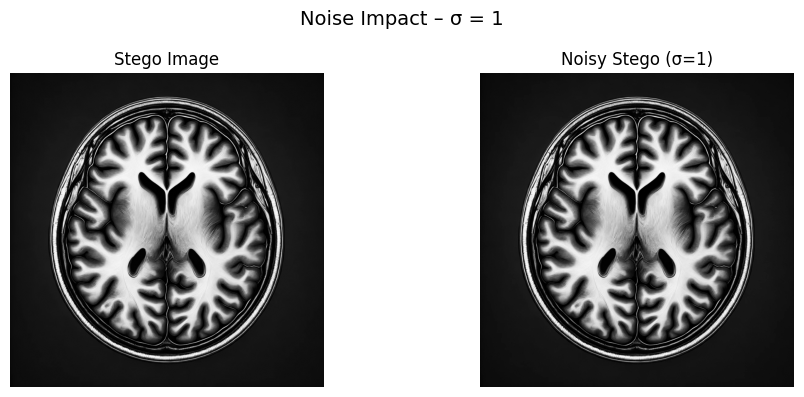

   Bitwise Accuracy: 72.67%
   Full Message Match: ❌
¶`'e%iàh/m8 G,ãtå`2Hn leäv §àzj+XefN`z<@` ¥`Dhyh iÃ#ËÕÂeAïî bItyo@hmp9°{llTkif%yw´ÅØPINjÄmD$\F!%P@FCbiPÌ  sIfn!3Dg#d(Aæs"Drw2mYA| B aîuET*g.ùk4h I-1gùNg t`p`0Vusô`3àbùlDÁ¥  eÎ%"Og%,HFR¨ªQT comp|è#îad\ÃRÇtó/ 
   	 	 °ð0  0 
   ð  ðßúiö=?"


🔹 Noise Level σ = 2


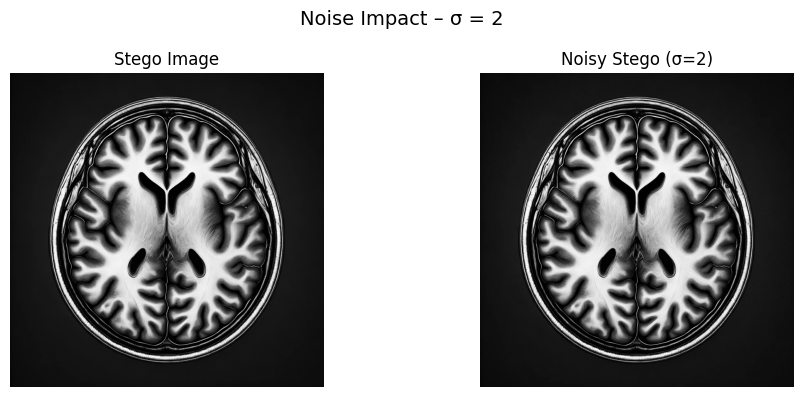

   Bitwise Accuracy: 59.28%
   Full Message Match: ❌
	ÀNaN+ÂgÊL'ú´%äEgãy°PÕN`ËB¡¨0uNh+©*pdl®Æ!S
Be@³äg^1%å7EpK{h¢,;|CdCØsAèíj ¦G<A¦fôPT!ÂÊÑéhèg,¬"×!ÒÐ7³ÚpÛð¼aùE62Àa¥·åD$¨µàI
iºÅyÅ1fPbNâ(u"XbF=#Id.b(¹1êbMæÂç}Hhl+|Õrj+bOìUHÜK&b·-T%$="v,ü,çdhZì¡¶¥nrn}­)âê1èYN$ÏÃ¹]"h¥~L ¤x
'"¹Ö«¤¸8%ýB@"E"'(IP_È/z ÂQ
Û&¥Ò:tÕ÷²ehÌó(sI¾túÚ2®þcûë¹ìÏ«sÉn×F`Æ%Ð"lb>D^ø!%àoY
ø )øVÈ";EÑT!øHÞ^!ì¼XþÜça·¹ëê¼þÝx{~¿_ÚWfÛ¤¤Ñ`ÂÄ1äñèàn
ãÐ:Î7îÿ;îû5Xð¿G&Ý¦ü
{ñ¿>ýÍ§þí·9íÑo£eG
ñ2´@yABDp{PÌGhÛn=VümÿÐ¨_eïvxÍ¨`R :S È¬Nº$1r ÃFEÙÄ@RßÊ 3Èà1  hÀ9EE
Á§Ç5¤òÏ¶¹cÝ~-¾îÜÿî×«yûØ91}0,ÛÖÂ8À·>Üfé×ÉaN>6ÛÓ.yå;"Ñÿ®núöd  0 @¨Á¢2 0HHPÊ*r ÆIE$ÎÂ¬à¦L¦aÉH  `l ±Áæõ{«Oý²òÞ	"


🔹 Noise Level σ = 3


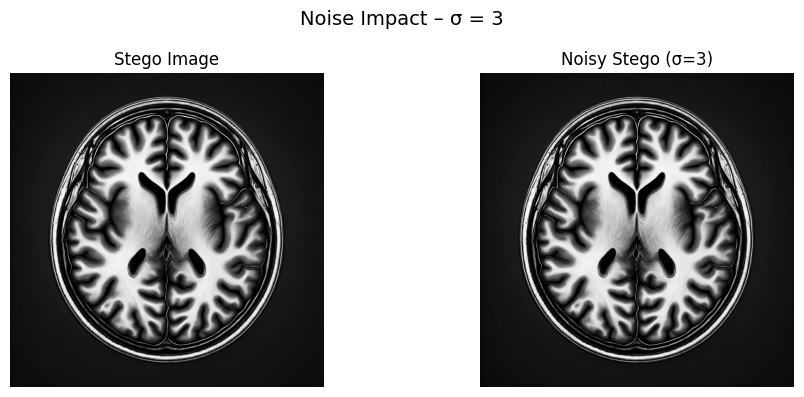

   Bitwise Accuracy: 51.61%
   Full Message Match: ❌
¼·aFJ<¤nÿ`·úðÃÖË@Qæ	Ã`.ðdCcW*èk/3v -ÎO<ò?/Vd&ÀöÕÆÌ*="M]UáC=ñT<`þ*yÖW6ø# WLÇadùøª,n¡ý`Á=Ô²c]äv|'ÑúEZQoÜ:`&µºJgÑa>~PCbÍaô°MÁØðøLZHÙV~pÝô/âÛ³´%HIþã);G¼¨ýbâ¦çf/lÑÏË¡nhU¢IÖ1}*:<+f¦lg.½ÜyxÁ£xH®lÑ·T6L
[
9kñt:_ïNÒ-HN	ÏSÔJG5-t¦Oå2Ýu2¨ÄÅ¯2ëâä>
Á©´¾3MrU
Dg!~w%m@_|<cúaZÞÉ¤´E¯ïAõr6²uFw*«~yæ~zcg"¯ÎÌ_:Gp§kzCÇq¹«"Q<X?'S¶ýS)JåÿiûËñ"~`58µ,#*E©¸êÃ"|Xøø6oð¶á12yl£Kc!á²ij;;Á4¤¦¡9&H±éÊð<X¬&Ý¼Å)¾üþdAýödSW¸­úíoº®ZXÝSÎ×ÚJ©¶Á "


🔹 Noise Level σ = 5


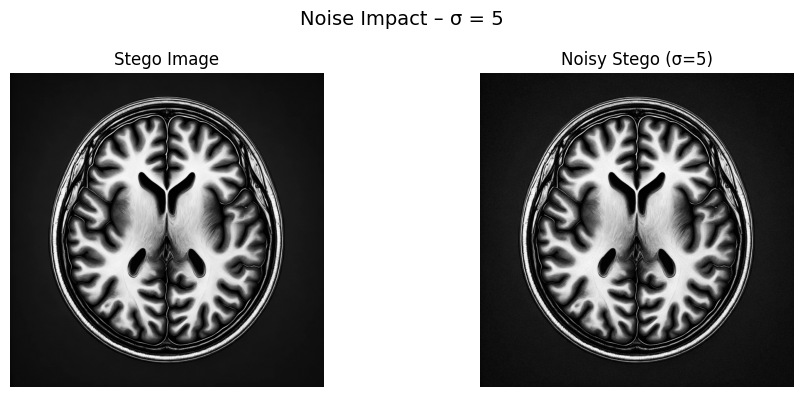

   Bitwise Accuracy: 51.27%
   Full Message Match: ❌
¡>#'`~ü'ª<.Ô k1	NQyüKØî<O¨5EéÔaÙ:úÂÉ¥Ìíb.p/ÅÑît5nDüââJíòX¹ò» 
Ö 2Mª§fTÃÌSÔÄ¤dv»fÓ&+GPélßDbÿ(÷íÛ®L]Õsª
q·`¶ÈõL1Ìk Ò-PìÑf#z°7s¹ºÖ mYO,-XjÝ9I}ÒÃ£UÜÐ	äýAn\4¸Î=hÄ_Ùù'?MfçSÖóàwÄ*®4ÿáÆlåÎÄ:¥¼"0êÌ]vè+øhL# %çmØðØ¼­èøá·,ÁÎ¥4ílêábò-þÁ-ÎoîÙ¬Æj§8'ê,µRÈ¾éq4:±Tjv7WÜËëõQÅk¤lbüëAëv':³A»¡cQ­ÇÿàÜ~Å¯å
5]{²wm­¤JÀ(.ïTÂ%ëUìHwëðÍá.IÑÔ¨vÅ÷Íg½hÁ±¤°01C43Ý°d¤À¯>óÚ<ø5"ï¦ÓNÍë^jf¸1åæZ­¤
I±wv¹±:=x½<þp~ Vïc9¼m»Þi³@S´C¦ÖaÞópìï]+ã¯ÀÆíws£÷æìh	¬í(áÎ\Ø3kÔyß+ÿXG¢¥e9	fDÄpÀj%<ÙAa°!§Á­k|<Þlæ, /Ì2ÐÊ»J9OÙ!aÄpô\$7Ü?­áÁêÃq¤`ÅÐïrê|/^C7nEó£îÙÕ³Õ9#´¶830sSBï{¿q*iÜ4e ÞîÔüØ4b´h	2¨Ô#¾æ³Ì´{xôñfà¸h§ÖúTîU»i¸y®ÚN£OBjõr,QÅÕÀI)oÄø7uðÖõ ´ª'°¨ß·yr0()ÃèØ#ÇÁ]1Kí¶Àú;¬?U¹°®þ­cÓâCCá¦¢Ä_UõTtÎl{{Ú {mfO²_VÀxhN
6CDó¡>`F°ª-{ÙNXoÉïTëmÊÞsÜÒ WvØM0ýf`ëVÍß@a­Lr¸1È¤e³ºu

In [9]:
# === Step 1: Define Gaussian Noise Function ===
def add_gaussian_noise(image, mean=0, std=5):
    """
    Adds Gaussian noise to a grayscale image.

    Parameters:
        image (np.ndarray): Grayscale image.
        mean (float): Mean of the Gaussian noise.
        std (float): Standard deviation of the noise.

    Returns:
        np.ndarray: Noisy image clipped to valid range.
    """
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = image + noise
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    return noisy_image

# === Assume original_img and stego_img are already created with embed_ird ===

# === Step 2: Visualize Original vs Stego ===
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(original_img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(stego_img, cmap='gray')
plt.title("Stego Image (with Embedded Message)")
plt.axis('off')

plt.suptitle("Comparison After Embedding", fontsize=14)
plt.tight_layout()
plt.show()

# === Step 3: Evaluate Robustness Under Gaussian Noise ===
print("\n" + "=" * 60)
print(" Evaluating Extraction Robustness Under Gaussian Noise")
print("=" * 60)

# Noise standard deviations to test
noise_levels = [0.5, 1, 2, 3, 5]

# Prepare the original binary message
original_binary = ''.join(f"{ord(c):08b}" for c in secret_message)
original_bit_length = len(original_binary)

for std in noise_levels:
    print(f"\n🔹 Noise Level σ = {std}")

    # Add Gaussian noise
    noisy_img = add_gaussian_noise(stego_img, std=std)

    # === Visual Comparison: Stego vs Noisy Stego ===
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(stego_img, cmap='gray')
    plt.title("Stego Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(noisy_img, cmap='gray')
    plt.title(f"Noisy Stego (σ={std})")
    plt.axis('off')

    plt.suptitle(f"Noise Impact – σ = {std}", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Extract hidden message from noisy image
    extracted_msg = extract_ird(noisy_img, verbose=False)

    # Compute bitwise accuracy
    extracted_binary = ''.join(f"{ord(c):08b}" for c in extracted_msg)
    match_bits = sum(a == b for a, b in zip(original_binary, extracted_binary))
    accuracy = round((match_bits / original_bit_length) * 100, 2) if original_bit_length else 0
    full_match = "✅" if extracted_msg == secret_message else "❌"

    # Display extraction result
    print(f"   Bitwise Accuracy: {accuracy:.2f}%")
    print(f"   Full Message Match: {full_match}")
    print(f"   Extracted Message: \"{extracted_msg}\"\n")


# Step 8: Steganographic Capacity Report

In [ ]:
@dataclass(frozen=True)
class Capacity:
    bits: int
    bytes: int
    chars: int

def compute_steganographic_capacity(
    image: np.ndarray,
    t1: int,
    t2: int
) -> Dict[str, Capacity]:
    """
    Compute conservative and dynamic payload capacities.

    Conservative: 1 bit per pixel.
    Dynamic (region-based):
      • Low (< t1):      3 bits/pixel
      • Medium (t1–t2):  2 bits/pixel
      • High (≥ t2):      1 bit/pixel

    Returns a dict with keys 'conservative' and 'dynamic', each mapping
    to a Capacity(bits, bytes, chars) object.
    """
    total_pixels = image.size

    # Conservative (uniform 1 bit/pixel)
    cons_bits  = total_pixels
    cons_bytes = cons_bits // 8
    cons_chars = cons_bytes

    # Masks for each region
    low_mask    = image < t1
    mid_mask    = (image >= t1) & (image < t2)
    high_mask   = image >= t2

    # Dynamic (3/2/1 bits per pixel)
    dyn_bits = (
        np.count_nonzero(low_mask)  * 3 +
        np.count_nonzero(mid_mask)  * 2 +
        np.count_nonzero(high_mask) * 1
    )
    dyn_bytes = dyn_bits // 8
    dyn_chars = dyn_bytes

    return {
        'conservative': Capacity(cons_bits,  cons_bytes,  cons_chars),
        'dynamic':      Capacity(dyn_bits,   dyn_bytes,   dyn_chars)
    }

def print_capacity_report(cap: Dict[str, Capacity]) -> None:
    """
    Nicely print the capacity estimates.
    """
    print("Steganographic Capacity Estimates")
    print("=================================")
    for label, c in cap.items():
        print(f"{label.title():12s}:")
        print(f"   • Bits : {c.bits}")
        print(f"   • Bytes: {c.bytes}")
        print(f"   • Chars: {c.chars}\n")
    print("Note:")
    print("  - 'Conservative' assumes 1 bit per pixel (lower bound).")
    print("  - 'Dynamic' uses region-based depths (true max under IRD).")

# === Example usage ===
t1, t2 =  86, 171
capacity = compute_steganographic_capacity(original_img, t1, t2)
print_capacity_report(capacity)


Steganographic Capacity Estimates
Conservative:
   • Bits : 1048576
   • Bytes: 131072
   • Chars: 131072

Dynamic     :
   • Bits : 2701180
   • Bytes: 337647
   • Chars: 337647

Note:
  - 'Conservative' assumes 1 bit per pixel (lower bound).
  - 'Dynamic' uses region-based depths (true max under IRD).
